# Вебинар 6. Двухуровневые модели рекомендаций


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [44]:
# !pip install implicit

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender
from tqdm import tqdm

tqdm.pandas()

In [46]:
data = pd.read_csv('../raw_data/retail_train.csv')
item_features = pd.read_csv('../raw_data/product.csv')
user_features = pd.read_csv('../raw_data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [47]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [48]:
recommender = MainRecommender(data_train_lvl_1)

100%|██████████| 5001/5001 [00:00<00:00, 92125.22it/s]


In [49]:
recommender.get_als_recommendations(2375, N=5)

[899624, 1037863, 951590, 1044078, 991546]

In [50]:
recommender.get_own_recommendations(2375, N=5)

[1068562, 1005935, 907099, 1112627, 1036501]

In [51]:
is_extend_with_top_popular=True
recommender.get_own_recommendations(user=2375, N=5, extend_with_top_popular=is_extend_with_top_popular)

[1068562, 1005935, 907099, 1112627, 1036501]

In [52]:
recommender.get_similar_items_recommendation(2375, N=5)

[889731, 1044078, 999207, 1062966, 9677366]

In [53]:
recommender.get_similar_users_recommendation(2375, N=5)

[1052155, 831125, 854133, 7147317, 911162]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [54]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [55]:
# Убирем из тестовой выборки пользоватлей, которые отсутствуют в обучащей. 

# Определяем уникальных пользователей которые есть в тестовом датасете. 

result_lvl_1 = result_lvl_1[result_lvl_1['user_id'].isin(data_train_lvl_1['user_id'].unique())]
result_lvl_1['user_id'].count()

2084

In [56]:
result_lvl_1['similar_items_recomender'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=5))
# precision = result_lvl_1.apply(lambda x: precision_at_k(x['similar_items_recomender'], x['actual'],  5), axis=1).mean() 
# precision

In [57]:
result_lvl_1['als_recmender'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=5))
# precision = result_lvl_1.apply(lambda x: precision_at_k(x['als_recmender'], x['actual'],  5), axis=1).mean() 
# precision

In [58]:
result_lvl_1['own_recomender'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=5))
# precision = result_lvl_1.apply(lambda x: precision_at_k(x['own_recomender'], x['actual'],  5), axis=1).mean() 
# precision

In [59]:
is_extend_with_top_popular=True
result_lvl_1['own_recomender_extend'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=5,extend_with_top_popular=is_extend_with_top_popular))
# precision = result_lvl_1.apply(lambda x: precision_at_k(x['own_recomender_extend'], x['actual'],  5), axis=1).mean() 
# precision

In [60]:
precision_dic = {'method':[], 'precission':[] }

column_names = ['similar_items_recomender',
                'als_recmender',
                'own_recomender',
                'own_recomender_extend'
]
for column_name in column_names:
    precision_dic['method'].append(column_name)
    precision_dic['precission'].append(result_lvl_1.apply(lambda x: precision_at_k(x[column_name], x['actual'],  5), axis=1).mean()) 

pd.DataFrame(precision_dic)

,method,precission
0,similar_items_recomender,0.086276
1,als_recmender,0.176775
2,own_recomender,0.242802
3,own_recomender_extend,0.242802


**B)**\* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  

In [64]:
precision = []
is_extend_with_top_popular=True
for k in tqdm([20, 50, 100, 200, 500]):
    result_lvl_1[f'own_recomender_{k}'] = result_lvl_1['user_id'].apply(lambda x: recommender. \
    get_own_recommendations(x, N=k,extend_with_top_popular=is_extend_with_top_popular))
    precision.append(result_lvl_1.apply(lambda x: precision_at_k(x[f'own_recomender_{k}'],
    x['actual'],  k), axis=1).mean()) 

100%|██████████| 5/5 [00:19<00:00,  3.83s/it]


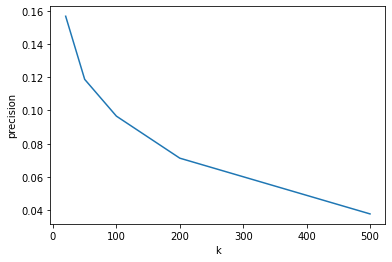

In [63]:
plt.plot([20, 50, 100, 200, 500], precision)
plt.ylabel('precision')
plt.xlabel('k')
plt.show()

**C)*** Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?

На графике видно, что с ростом к-ва рекомндуемых товров к-во падает.
Кроме того, если брать большое к-во товаров для рекомендации, они не будут помещаться в соответствующую строку на странице магазина. И велика вероятность, что пользователь х даже не увидит. Поэтому - 5-7 товаров, на мой взгляд будет оптимальным к-вом. Максимум 10.

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [ ]:
# your_code

### Финальный проект

Мы уже прошли всю необходимуб теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - precision@5. Порог для уcпешной сдачи проекта precision@5 > 25%
- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно, но крайне желательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и csv файл с рекомендациями 